In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/salabed/anaconda3/envs/rocksdb/lib/python3.8/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


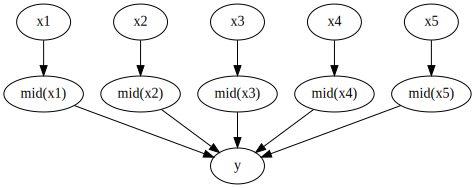

In [2]:
import dataclasses

import botorch
import networkx as nx
import torch
import math
import sysgym.params.boxes as boxes
import utils
from sysgym.params import ParamsSpace

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}


@dataclasses.dataclass(init=False, frozen=True)
class MichalewiczSpace(ParamsSpace):
    x1: boxes.ContinuousBox = boxes.ContinuousBox(0.0, math.pi)
    x2: boxes.ContinuousBox = boxes.ContinuousBox(0.0, math.pi)
    x3: boxes.ContinuousBox = boxes.ContinuousBox(0.0, math.pi)
    x4: boxes.ContinuousBox = boxes.ContinuousBox(0.0, math.pi)
    x5: boxes.ContinuousBox = boxes.ContinuousBox(0.0, math.pi)


problem = botorch.test_functions.Michalewicz(negate=True, dim=5, noise_std=0.0001)
space = MichalewiczSpace()
dag = nx.DiGraph()
dag.add_node("y")
for i in space:
    dag.add_node(i)
    # One term
    # dag.add_edges_from([(i, f"z({i})"), (f"z({i})", "y")])
    # Both terms:
    # dag.add_edges_from([(i, f"f1({i})"), (i, f"f2({i})"),
    #                     (f"f1({i})", "y"), (f"f2({i})", "y")
    #                     ])
    dag.add_edge(i, f'mid({i})')
    dag.add_edge(f'mid({i})', 'y')

utils.draw(dag)



In [3]:
from typing import Mapping
import bench_util


def eval_structure(x: torch.Tensor) -> torch.Tensor:
    m = 10
    return torch.sin(x) * torch.sin(problem.i * x ** 2 / math.pi) ** (2 * m)


In [27]:
from notebooks.bobn_ch import bobn
from autorocks.viz import plots_setup

bobn = bobn.BoBn(dag,
                 params=space,
                 objectives={'y'})

initial_train_x, initial_train_y = plots_setup.generate_data(3, problem)

initial_structure = eval_structure(initial_train_x)

initial_data = {
    'y': initial_train_y.tolist()
}
for idx, i in enumerate(space):
    initial_data[i] = initial_train_x[:, idx].tolist()
    initial_data[f"mid({i})"] = initial_structure[:, idx].tolist()

observations = {}
observations.update(initial_data)
best_f = float(initial_train_y.max())


initial_data

group={'x1', 'mid(x1)'}
group={'x3', 'mid(x3)'}
group={'mid(x5)', 'x5'}
group={'x2', 'mid(x2)'}
group={'mid(x4)', 'x4'}
Built independent subgraph: {'x1', 'y', 'mid(x1)'}
Built independent subgraph: {'y', 'x3', 'mid(x3)'}
Built independent subgraph: {'mid(x5)', 'x5', 'y'}
Built independent subgraph: {'x2', 'mid(x2)', 'y'}
Built independent subgraph: {'mid(x4)', 'y', 'x4'}


{'y': [0.6699290871620178, 1.2820683717727661, 0.8331722617149353],
 'x1': [0.6822190880775452, 2.0174098014831543, 2.3939318656921387],
 'mid(x1)': [1.5200494275039826e-17, 0.4185870587825775, 0.3552526533603668],
 'x2': [1.4683748483657837, 2.0143024921417236, 0.02082197181880474],
 'mid(x2)': [0.6699552536010742, 2.759286189757404e-06, 0.0],
 'x3': [2.4918103218078613, 0.2377348393201828, 2.0730514526367188],
 'mid(x3)': [3.7811323516656614e-10,
  1.0254586255498638e-26,
  0.01675550267100334],
 'x4': [0.16523174941539764, 1.82975172996521, 1.019849181175232],
 'mid(x4)': [1.0871975158382377e-30, 0.11916247010231018, 0.4611370265483856],
 'x5': [1.9938451051712036, 1.0303277969360352, 0.6083271503448486],
 'mid(x5)': [6.373565187360719e-28, 0.7444364428520203, 4.47501315647969e-06]}

In [52]:
# BO loop
results = []

hypothesis_values = [
    {"mid(x2)": 0, "mid(x5)": 0},
    {"mid(x2)": -1, "mid(x5)": 0},
    {"mid(x2)": 0, "mid(x5)": 2},
    {"mid(x2)": 2, "mid(x5)": 2}]


for hypothesis_value in hypothesis_values:
    next_candidate, acqf_values = bobn.opt(observations,
                                           conditioning_values_override=hypothesis_value,
                                           return_acqf_values=True)
    next_candidate_tensor = []
    for p in space:
        next_candidate_tensor.append(next_candidate[p])
    next_candidate_tensor = torch.tensor(next_candidate_tensor)
    y = float(problem(next_candidate_tensor))
    vals = {}
    for k, v in acqf_values.items():
        vals[k] = float(v)
    results.append(
        {"hypothesis": str(hypothesis_value), "y": y, **vals}
    )

In [53]:
import pandas as pd

df = pd.DataFrame(results).drop(columns={"x2,mid(x2),y",  "x5,mid(x5),y"}).reset_index()
df

,index,hypothesis,y,"x1,mid(x1),y","x3,mid(x3),y","x4,mid(x4),y"
0,0,"{'mid(x2)': 0, 'mid(x5)': 0}",1.361655,0.087106,0.099801,0.031008
1,1,"{'mid(x2)': -1, 'mid(x5)': 0}",0.525008,0.282665,0.388694,0.206872
2,2,"{'mid(x2)': 0, 'mid(x5)': 2}",1.696909,0.000532,0.252132,0.338801
3,3,"{'mid(x2)': 2, 'mid(x5)': 2}",1.002114,0.132945,0.157681,0.096379


In [54]:
melted_df = df.melt(id_vars=['index', 'hypothesis', 'y'])
melted_df

,index,hypothesis,y,variable,value
0,0,"{'mid(x2)': 0, 'mid(x5)': 0}",1.361655,"x1,mid(x1),y",0.087106
1,1,"{'mid(x2)': -1, 'mid(x5)': 0}",0.525008,"x1,mid(x1),y",0.282665
2,2,"{'mid(x2)': 0, 'mid(x5)': 2}",1.696909,"x1,mid(x1),y",0.000532
3,3,"{'mid(x2)': 2, 'mid(x5)': 2}",1.002114,"x1,mid(x1),y",0.132945
4,0,"{'mid(x2)': 0, 'mid(x5)': 0}",1.361655,"x3,mid(x3),y",0.099801
5,1,"{'mid(x2)': -1, 'mid(x5)': 0}",0.525008,"x3,mid(x3),y",0.388694
6,2,"{'mid(x2)': 0, 'mid(x5)': 2}",1.696909,"x3,mid(x3),y",0.252132
7,3,"{'mid(x2)': 2, 'mid(x5)': 2}",1.002114,"x3,mid(x3),y",0.157681
8,0,"{'mid(x2)': 0, 'mid(x5)': 0}",1.361655,"x4,mid(x4),y",0.031008
9,1,"{'mid(x2)': -1, 'mid(x5)': 0}",0.525008,"x4,mid(x4),y",0.206872


In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("ggplot")
sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})
sns.set_context("paper")  # , font_scale=1.5, rc={"lines.linewidth": 1.5})
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["font.family"] = "Arial"
plt.rc("text", usetex=False)
plt.rc("xtick", labelsize="small")
plt.rc("ytick", labelsize="small")
plt.rc("axes", labelsize="medium")
plt.rc("pdf", use14corefonts=True)

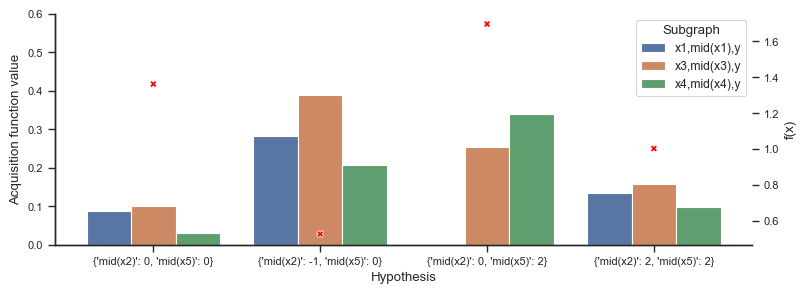

In [88]:
fig, ax = plt.subplots(figsize=(9, 3))

ax = sns.barplot(data=melted_df, x="hypothesis", y="value", hue="variable", ax=ax)
# ax.axhline(problem.optimal_value, ls='dashdot', label="Optimal value", color='red')
ax.set(xlabel="Hypothesis", ylabel="Acquisition function value", ylim=(0,0.6))
ax.legend(title="Subgraph", loc="upper right")
ax2 = plt.twinx()
sns.scatterplot(data=melted_df, x="index", y="y", color="red", style=True, markers="X", ax=ax2, legend=False)
ax2.set(ylabel="f(x)")

output_location = "/home/salabed/workspace/latex/thesis/phd_dissertation/Chapters/BoBn/Figures"
output_format = "svg"
fig.savefig(f"{output_location}/acf_values.{output_format}", bbox_inches="tight",
            format=f"{output_format}",
            dpi=300)
output_format = "pdf"
fig.savefig(f"{output_location}/acf_values.{output_format}", bbox_inches="tight",
            format=f"{output_format}",
            dpi=300)